Sources used
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://datascience.stackexchange.com/questions/65979/what-is-the-correct-way-to-call-keras-flow-from-directory-method
* https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
* https://github.com/keras-team/keras/issues/5862#issuecomment-647559571
* https://keras.io/api/preprocessing/image/
* https://stackoverflow.com/questions/57092637/how-to-fit-keras-imagedatagenerator-for-large-data-sets-using-batches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
# define constants
#ORIGINAL_PARENT_DIR = './FRUIT-16K' # enter path to original dataset
ORIGINAL_PARENT_DIR = '/content/drive/MyDrive/FRUIT-16K' # enter path to original dataset
PREPROCESSED_PARENT_DIR = './FRUIT-16K-PREPROCESSED' # enter path to folder where you want the preprocessed data to go (code will create it)

CLASSES = []
for directory in os.listdir(ORIGINAL_PARENT_DIR):
    path = os.path.join(ORIGINAL_PARENT_DIR, directory)
    if os.path.isdir(path) and not directory.startswith('.'):
        CLASSES.append(directory)
print(CLASSES)

# define hyper-parameters
BATCH_SIZE = 64
IMAGE_HEIGHT = 56
IMAGE_WIDTH = 56
SEED = 42
TEST_SIZE = 0.2

['F_Tomato', 'S_Mango', 'S_Lulo', 'F_Tamarillo', 'S_Tomato', 'S_Orange', 'S_Lemon', 'S_Tamarillo', 'S_Strawberry', 'S_Banana', 'F_Orange', 'F_Banana', 'F_Lemon', 'F_Lulo', 'F_Strawberry', 'F_Mango']


In [ ]:
def read_image(path):
    img = load_img(path, target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = img_to_array(img)
    return img_arr

def get_images_df(path):
    # walk through the path and create a dataframe
    # that has one column for the path to the image
    # and the other with the class name
    images_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.startswith('.'):
                # add to dict [ image | class_name ]
                class_name = root.split(os.sep)[-1]
                image_path = os.path.join(root, file)
                images_data.append({
                    'image_path': image_path,
                    'class': class_name
                })
    df = pd.DataFrame(images_data)
    
    return df

def create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path): 
    # create the train and test folders
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    os.mkdir(train_path)
    os.mkdir(test_path)
        
    # for each class, make a subfolder
    for class_name in classes:
        os.mkdir(os.path.join(train_path, class_name))
        os.mkdir(os.path.join(test_path, class_name))
    
    # transfer files from dataframe image path to the appropriate
    # subfolder in save_path (sub folders based on class name)
    # also create x_train_final and x_test_final which will
    # store pixels of image
    x_train_final = []
    x_test_final = []
    for x_val, y_val in zip(x_train, y_train):
        new_path = os.path.join(train_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_train_final.append(img_arr)
    for x_val, y_val in zip(x_test, y_test):
        new_path = os.path.join(test_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_test_final.append(img_arr)
    
    return np.asarray(x_train_final), np.asarray(x_test_final), y_train, y_test
        
def transfer_data(original_dir, new_dir, classes, test_size):
    # get the images as a dataframe
    # this dataframe has two columns, one with
    # the path to the image in original_dir and one with
    # the class name
    original_df = get_images_df(original_dir)
    
    # split the df into train and test
    x, y = original_df['image_path'], original_df['class']
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = test_size)
    
    # create the new_dir folder
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    # transfer all the data from original_df to new_dir
    # with the appropriate formatting and get back the
    # split with the x arrays having the pixels associated
    # with the images and the y arrays having the label
    x_train, x_test, y_train, y_test = create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path = new_dir)
    
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = transfer_data(ORIGINAL_PARENT_DIR, PREPROCESSED_PARENT_DIR, classes = CLASSES, test_size = TEST_SIZE)

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13881679159251050868
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11067626629308699052
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf

# augment and preprocess the training data
#train_image_data_generator = ImageDataGenerator(rescale = 1./255, zca_whitening=True, validation_split = 0.2)
train_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale = 1./255, rotation_range=30,
                                          zoom_range=0.15, width_shift_range=0.2,
                                          height_shift_range=0.2, shear_range=0.15,
                                          horizontal_flip=True, fill_mode="nearest", validation_split = 0.2)

#valGenerator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

print("done with train image generator")

# fit the train_image_data_generator to the train set
# only run this line of code if featurewise_center or featurewise_std_normalization or zca_whitening set to True
print(len(x_train))
#train_image_data_generator.fit(x_train)
print("done with fit")

# do NOT augment the testing data
test_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,rescale = 1./255)

# create the training generator and the testing generator from their respective folders
train_generator = train_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'train'), 
                                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                                 classes = CLASSES, batch_size = BATCH_SIZE, 
                                                                 shuffle = True, seed = SEED, subset='training')

validation_generator = train_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'train'), 
                                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                                 classes = CLASSES, batch_size = BATCH_SIZE, 
                                                                 shuffle = True, seed = SEED, subset='validation')


#print(PREPROCESSED_PARENT_DIR)


test_generator = test_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'test'), 
                                                               target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                               classes = CLASSES, batch_size = BATCH_SIZE, 
                                                               shuffle = True, seed = SEED)

print("done with flow")

done with train image generator
12800
done with fit
Found 10247 images belonging to 16 classes.
Found 2553 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.
done with flow


A few potentially useful links/notes for the ML team
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator (check out the Example of using `.flow_from_directory(directory)` section) for how (I think) you can use the fit function with generators)
* You can access the mapping from class to indices through `train_generator.class_indices` or `train_generator.class_indices`
* https://stackoverflow.com/questions/61864244/how-to-avoid-augmenting-data-in-validation-split-of-keras-imagedatagenerator
* https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
* https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

In [ ]:
# verify that the class index mapping are the same (should always be the case)
print(test_generator.class_indices == train_generator.class_indices)
print(train_generator.class_indices)
print(len(train_generator.class_indices))

True
{'F_Tomato': 0, 'S_Mango': 1, 'S_Lulo': 2, 'F_Tamarillo': 3, 'S_Tomato': 4, 'S_Orange': 5, 'S_Lemon': 6, 'S_Tamarillo': 7, 'S_Strawberry': 8, 'S_Banana': 9, 'F_Orange': 10, 'F_Banana': 11, 'F_Lemon': 12, 'F_Lulo': 13, 'F_Strawberry': 14, 'F_Mango': 15}
16


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


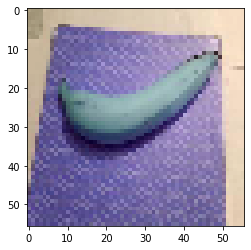

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


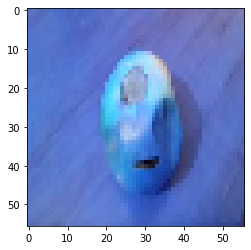

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


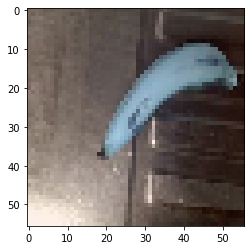

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


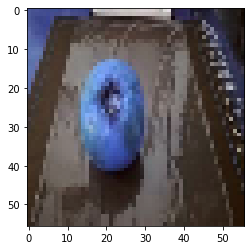

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


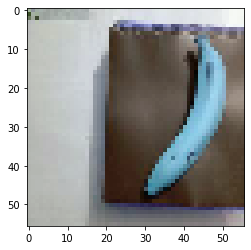

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


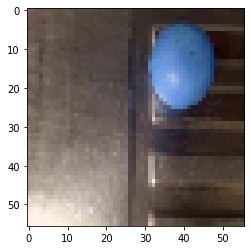

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


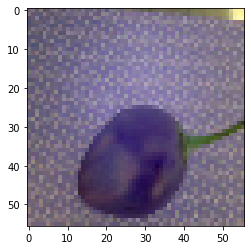

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


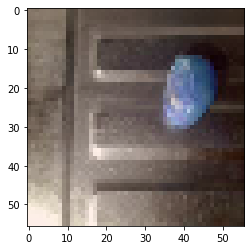

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


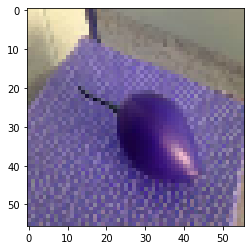

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


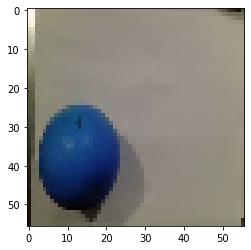

In [ ]:
for _ in range(10):
    img, label = test_generator.next()
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


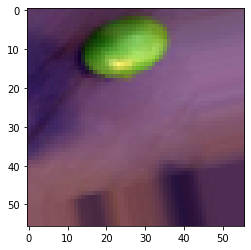

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


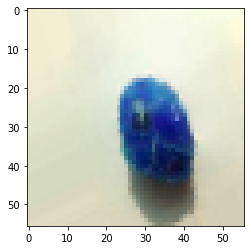

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


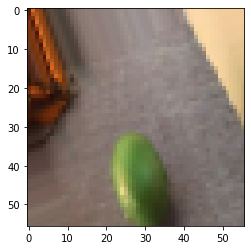

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


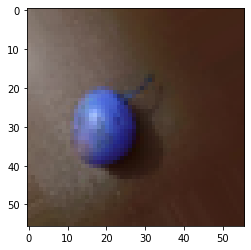

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


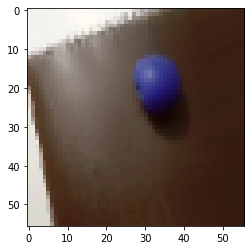

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


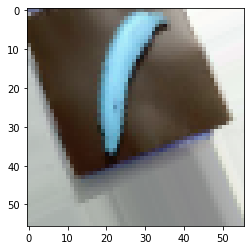

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


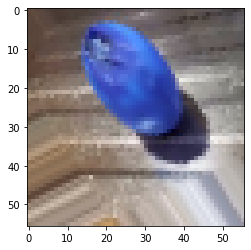

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


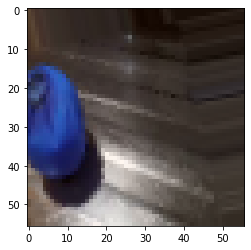

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


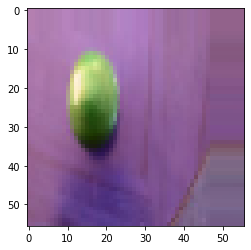

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


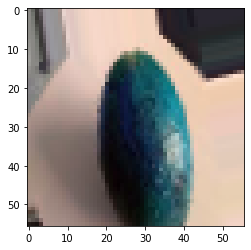

In [ ]:
for _ in range(10):
    img, label = validation_generator.next()
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


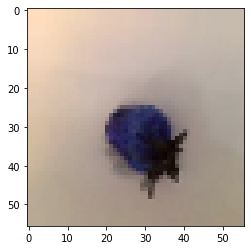

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


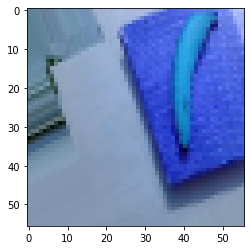

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


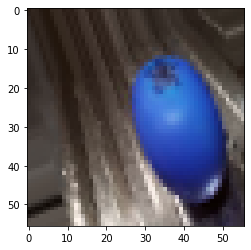

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


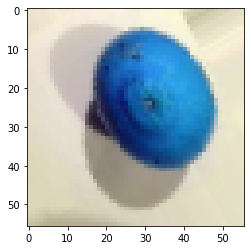

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


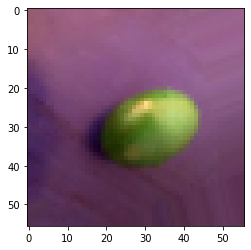

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


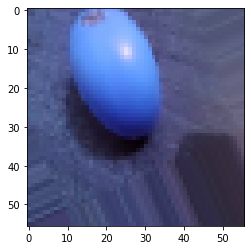

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


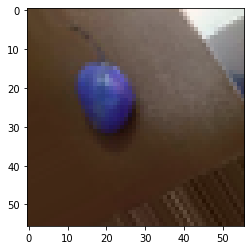

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


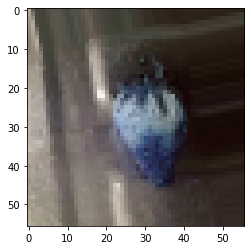

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


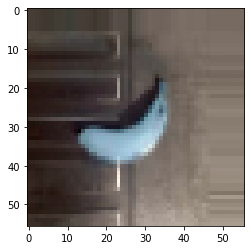

(64, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


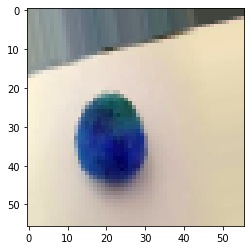

In [ ]:
for _ in range(10):
    img, label = train_generator.next()
    print(img.shape)
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1228590147354726626
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9281865497126095064
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import sys
!{sys.executable} -m pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 6.4 MB/s 


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import History 
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 2)):
      model.add(
          keras.layers.Conv2D(
              # Tune number of units separately.
              filters=hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
              kernel_size=hp.Choice('Kernel_Size', values = [3,5,9]),
              activation='relu'
          )
      )
    model.add(
      keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2)
      )
    )
    model.add(Flatten())
    model.add(Dense(hp.Choice("Dense Layer Size 1", [64, 128, 256, 512, 1024]), activation = 'relu'))
    if hp.Boolean("dropout1"):
      model.add(Dropout(hp.Choice("Dropout #1 %", values = [0.10,0.20,0.25,0.50])))
    model.add(Dense(hp.Choice("Dense Layer Size 2", [64, 128, 256, 512, 1024]), activation = 'relu'))
    if hp.Boolean("dropout2"):
      model.add(Dropout(hp.Choice("Dropout #2 %", values = [0.10,0.20,0.25,0.50])))
    model.add(Dense(len(train_generator.class_indices), activation='softmax'))

    #print(len(train_generator.class_indices))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
                  metrics=['accuracy'])

    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

    return model 

#history = History()

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_epochs=15
)

tuner.search(train_generator,epochs=35,validation_data=validation_generator,callbacks=[earlyStop])

#model.fit(train_generator,
#          batch_size=64,
#          epochs=30,
#          verbose=1,
#          validation_data=validation_generator,
#          callbacks=[history])

#score = model.evaluate(test_generator, verbose=0)
#print('\nTest loss:', score[0])
#print('Test accuracy:', score[1])

Trial 30 Complete [00h 07m 42s]
val_accuracy: 0.7418723106384277

Best val_accuracy So Far: 0.7830004096031189
Total elapsed time: 01h 15m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.space)


[Int(name: "num_layers", min_value: 1, max_value: 2, step: 1, sampling: None, default: 1), Int(name: "units_0", min_value: 16, max_value: 128, step: 16, sampling: None, default: 16), Choice(name: "Kernel_Size", values: [3, 5, 9], ordered: True, default: 3), Choice(name: "Dense Layer Size 1", values: [64, 128, 256, 512, 1024], ordered: True, default: 64), Boolean(name: "dropout1", default: False), Choice(name: "Dense Layer Size 2", values: [64, 128, 256, 512, 1024], ordered: True, default: 64), Boolean(name: "dropout2", default: False), Float(name: "lr", min_value: 0.0001, max_value: 0.01, step: None, sampling: log, default: 0.0001), Int(name: "units_1", min_value: 16, max_value: 128, step: 16, sampling: None, default: 16), Choice(name: "Dropout #1 %", values: [0.1, 0.2, 0.25, 0.5], ordered: True, default: 0.1), Choice(name: "Dropout #2 %", values: [0.1, 0.2, 0.25, 0.5], ordered: True, default: 0.1)]


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=35, validation_data=validation_generator)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/35
161/161 [==============================] - 27s 164ms/step - loss: 1.7180 - accuracy: 0.4359 - val_loss: 1.8129 - val_accuracy: 0.4027
Epoch 2/35
161/161 [==============================] - 26s 161ms/step - loss: 0.8773 - accuracy: 0.7005 - val_loss: 1.3837 - val_accuracy: 0.5860
Epoch 3/35
161/161 [==============================] - 26s 160ms/step - loss: 0.6163 - accuracy: 0.7814 - val_loss: 1.4208 - val_accuracy: 0.5789
Epoch 4/35
161/161 [==============================] - 26s 161ms/step - loss: 0.5206 - accuracy: 0.8183 - val_loss: 1.0692 - val_accuracy: 0.6639
Epoch 5/35
161/161 [==============================] - 24s 152ms/step - loss: 0.4261 - accuracy: 0.8538 - val_loss: 0.9689 - val_accuracy: 0.7101
Epoch 6/35
161/161 [==============================] - 25s 153ms/step - loss: 0.3354 - accuracy: 0.8821 - val_loss: 1.0385 - val_accuracy: 0.6866
Epoch 7/35
161/161 [==============================] - 25s 153ms/step - loss: 0.3185 - accuracy: 0.8882 - val_loss: 0.8865 - val_ac

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

history = History()

# Retrain the model
hypermodel.fit(train_generator, epochs=best_epoch, validation_data=validation_generator,callbacks=[history])

Epoch 1/31
161/161 [==============================] - 27s 167ms/step - loss: 1.6764 - accuracy: 0.4449 - val_loss: 1.6452 - val_accuracy: 0.4434
Epoch 2/31
161/161 [==============================] - 27s 165ms/step - loss: 0.8604 - accuracy: 0.7068 - val_loss: 1.3882 - val_accuracy: 0.5633
Epoch 3/31
161/161 [==============================] - 26s 163ms/step - loss: 0.6236 - accuracy: 0.7881 - val_loss: 1.2203 - val_accuracy: 0.6052
Epoch 4/31
161/161 [==============================] - 27s 169ms/step - loss: 0.5268 - accuracy: 0.8173 - val_loss: 1.1471 - val_accuracy: 0.6377
Epoch 5/31
161/161 [==============================] - 27s 166ms/step - loss: 0.4158 - accuracy: 0.8534 - val_loss: 1.0369 - val_accuracy: 0.6827
Epoch 6/31
161/161 [==============================] - 27s 169ms/step - loss: 0.3420 - accuracy: 0.8784 - val_loss: 0.8905 - val_accuracy: 0.7286
Epoch 7/31
161/161 [==============================] - 26s 165ms/step - loss: 0.3262 - accuracy: 0.8880 - val_loss: 0.9357 - val_ac

In [ ]:
eval_result = hypermodel.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

50/50 [==============================] - 5s 90ms/step - loss: 0.2396 - accuracy: 0.9341
[test loss, test accuracy]: [0.2396373599767685, 0.9340624809265137]
